In [1]:
!pip install yake numpy gluoncv matplotlib torch=="1.13.0" mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.1/890.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 2.9 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cpu
    Uninstalling torch-2.0.0+cpu:
 

In [2]:
# import block
import yake
import pandas as pd
import os
import glob
import csv
import itertools
import string
import pickle
import math
import nltk

from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/gluoncv/__init__.py:40: UserWarning: Both `mxnet==1.9.1` and `torch==1.13.0+cu117` are installed. You might encounter increased GPU memory footprint if both framework are used at the same time.
  warnings.warn(f'Both `mxnet=={mx.__version__}` and `torch=={torch.__version__}` are installed. '


In [3]:
kw_extractor = yake.KeywordExtractor()
language = "en"
max_ngram = 1
deduplication_threshold = 0.9
nKeywords = 5
customExtractor = yake.KeywordExtractor(lan=language, n = max_ngram, dedupLim = deduplication_threshold, top = nKeywords, features=None)

# descriptors = pd.read_csv("/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv")
# descriptors[0:10]

fnames = glob.glob("/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/*.jpg")

print(f"{len(fnames)} images")

comments = pd.read_csv("/kaggle/input/flickr-image-dataset/flickr30k_images/results.csv", sep="|")


31783 images


In [4]:
comments.head()

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .

In [5]:
descriptions = {}

for i in range(len(comments)):
    if comments.loc[i, "image_name"] in descriptions:
        descriptions[comments.loc[i, "image_name"]].append(comments.loc[i, " comment"])
    else:
        descriptions[comments.loc[i, "image_name"]] = [comments.loc[i, " comment"]]
        
        
print("consolidating complete")

print("first 10 ")
for x in itertools.islice(descriptions.items(), 10):
    print(x)
    print("\n")
    
sampleSet = []
testing = False

if testing:
    n = 250
    for key in itertools.islice(descriptions.keys(), n):
        sampleSet.append((key, descriptions[key]))

    print(f"sampleset of {n} imgs 5 captions each created")
else:
    for key in descriptions.keys():
        sampleSet.append((key, descriptions[key]))
        
    print("all items added to sampleSet")
    
n = len(sampleSet)

consolidating complete
first 10 
('1000092795.jpg', [' Two young guys with shaggy hair look at their hands while hanging out in the yard .', ' Two young , White males are outside near many bushes .', ' Two men in green shirts are standing in a yard .', ' A man in a blue shirt standing in a garden .', ' Two friends enjoy time spent together .'])


('10002456.jpg', [' Several men in hard hats are operating a giant pulley system .', ' Workers look down from up above on a piece of equipment .', ' Two men working on a machine wearing hard hats .', ' Four men on top of a tall structure .', ' Three men on a large rig .'])


('1000268201.jpg', [' A child in a pink dress is climbing up a set of stairs in an entry way .', ' A little girl in a pink dress going into a wooden cabin .', ' A little girl climbing the stairs to her playhouse .', ' A little girl climbing into a wooden playhouse ', ' A girl going into a wooden building .'])


('1000344755.jpg', [' Someone in a blue shirt and hat is stand

In [6]:
# YAKE params
language = 'en'
max_ngram = 1
deduplication_thresh = 0.9
deduplication_algo = 'seqm'
winSize = 1
# nKeywords = 10 -> dependent on caption length, try for approx 1/3 caption length and see?

In [7]:
# TODO: this works for keyword extraction for now, but redo later to get more relevant/searchable keywords?
# i.e. first image 1000092795.jpg, people won't search for just 'green' or 'enjoy' but they would search for 'man' 'garden' 'bushes'
# create a dictionary with these types of highly searchable words (WHAT DO THEY HAVE IN COMMON) and make keywords more USEFUL based on that

sampleKw = []
for item in sampleSet:
    key, caps = item
    keywords = []
    tagged = []
    for cap in caps:
        if type(cap) == float and math.isnan(cap): continue
        cap = " ".join(cap.lower().translate(str.maketrans('', '', string.punctuation)).split())
        nKeywords = int(len(cap.split()) // 3)
        ctag = nltk.pos_tag(nltk.word_tokenize(cap))
        for x in ctag:
            tagged.append(x)

        kw_extr = yake.KeywordExtractor(
            lan = language,
            n = max_ngram,
            dedupLim = deduplication_thresh,
            dedupFunc = deduplication_algo,
            windowsSize = winSize,
            top = nKeywords, 
            features = None
        )
        kw = kw_extr.extract_keywords(cap)
        # extracted in format (word, relevance_score) where lower relevance_score -> higher relevance to string

        for w in kw: keywords.append(w)
    
    # add new shit to pipeline -> sort keywords then keep by type of speech -> all nouns, some verbs (action verbs -> hiking, eating, skiing, running, etc)?
    # then tokenize keywords same way we'd tokenize the search input to match keywords
    keywords.sort(key=lambda x: x[1])
#     tagged = [x for x in [nltk.pos_tag(nltk.word_tokenize(cap)) for cap in caps]]
    dicttag = {w:tos for w,tos in tagged}
#     print(dicttag)
#     print(keywords)
    isoKw = set([kw[0] for kw in keywords if dicttag[kw[0]] in ['NN', 'VB']])
    finWords = [x for x in list(isoKw)[0:7]]
    sampleKw.append((key, finWords))
#     print(f"image: {key} | found keywords: {finWords}")
    
print(len(sampleKw))
print(sampleKw[0:15])
    
filename=f"{n}kw.pkl"
pickle.dump(sampleKw, open(filename, 'wb'))

print("data dumped to /kaggle/working/flickrKeywords.pkl")


31783
[('1000092795.jpg', ['man', 'hair', 'garden', 'yard']), ('10002456.jpg', ['equipment', 'rig', 'system', 'structure', 'piece']), ('1000268201.jpg', ['playhouse', 'child', 'pink', 'building', 'set', 'girl', 'cabin']), ('1000344755.jpg', ['shirt', 'man', 'hat', 'building', 'ladder', 'window']), ('1000366164.jpg', ['kitchen', 'guy', 'shirt', 'camera', 'food', 'meal', 'stove']), ('1000523639.jpg', ['guitar', 'guy', 'shirt', 'man', 'photo', 'coat']), ('1000919630.jpg', ['man', 'chair', 'toy', 'lion', 'animal']), ('10010052.jpg', ['adult', 'woman', 'street', 'lot', 'ear', 'girl', 'wearing']), ('1001465944.jpg', ['man', 'woman', 'building', 'gate', 'railing']), ('1001545525.jpg', ['night', 'rail', 'germany']), ('1001573224.jpg', ['ballet', 'form', 'room', 'class', 'window', 'sequence']), ('1001633352.jpg', ['woman', 'top', 'staircase']), ('1001773457.jpg', ['street', 'pavement', 'road', 'dog']), ('1001896054.jpg', ['john', 'clothing', 'man', 'road', 'safety', 'street', 'orange']), ('1001

In [8]:
allkeywordset = set([])
for img, cap in sampleKw:
    allkeywordset = allkeywordset.union(cap)

In [9]:
len(allkeywordset) # unacceptable, group into smaller things of related words i.e. guy, man are redundant descriptors

6980

In [10]:
net = model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

223070KB [00:05, 44360.12KB/s]                            


In [11]:
print(net.classes)

('aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')


preprocessed shape (1, 3, 769, 512)
yolo completed
expected captions ['man', 'hair', 'garden', 'yard']
plotted
preprocessed shape (1, 3, 512, 684)
yolo completed
expected captions ['equipment', 'rig', 'system', 'structure', 'piece']
plotted
preprocessed shape (1, 3, 683, 512)
yolo completed
expected captions ['playhouse', 'child', 'pink', 'building', 'set', 'girl', 'cabin']
plotted
preprocessed shape (1, 3, 512, 769)
yolo completed
expected captions ['shirt', 'man', 'hat', 'building', 'ladder', 'window']
plotted
preprocessed shape (1, 3, 512, 683)
yolo completed
expected captions ['kitchen', 'guy', 'shirt', 'camera', 'food', 'meal', 'stove']
plotted
preprocessed shape (1, 3, 512, 769)
yolo completed
expected captions ['guitar', 'guy', 'shirt', 'man', 'photo', 'coat']
plotted
preprocessed shape (1, 3, 769, 512)
yolo completed
expected captions ['man', 'chair', 'toy', 'lion', 'animal']
plotted
preprocessed shape (1, 3, 764, 512)
yolo completed
expected captions ['adult', 'woman', 'street

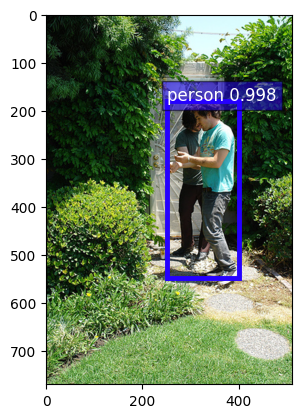

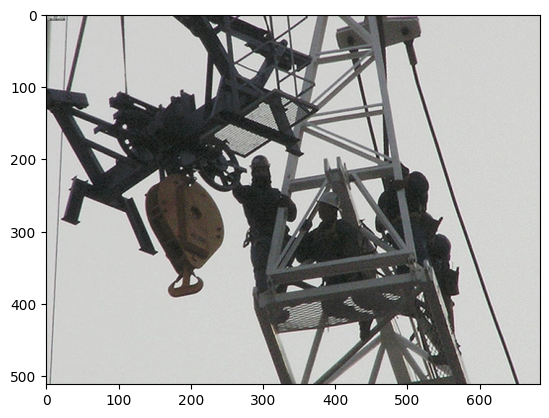

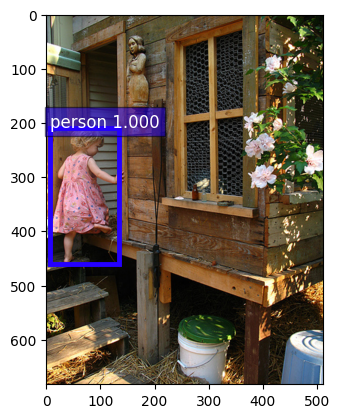

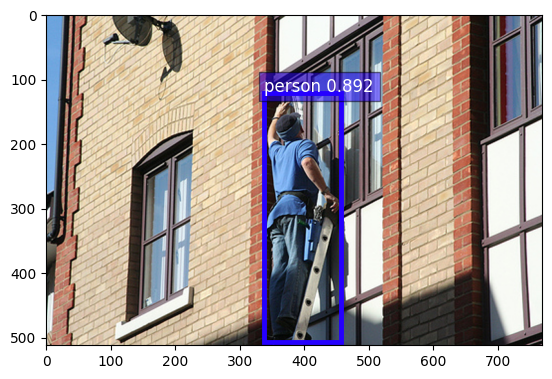

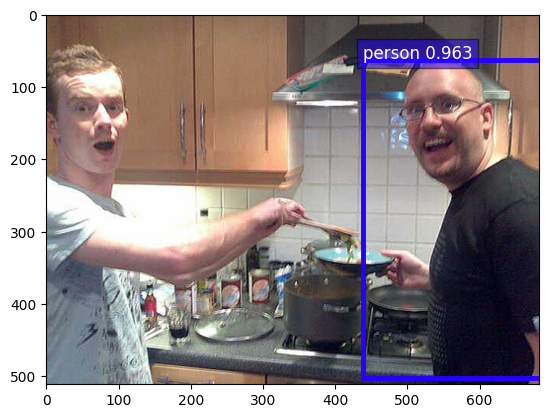

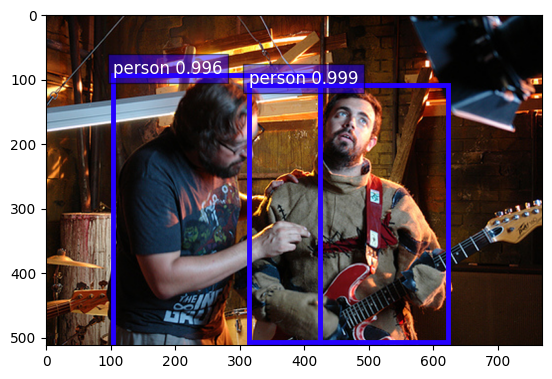

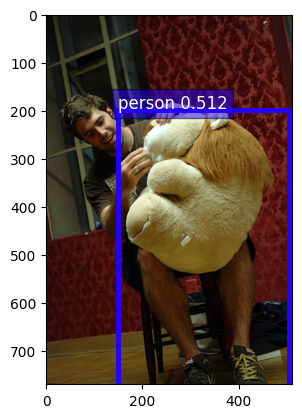

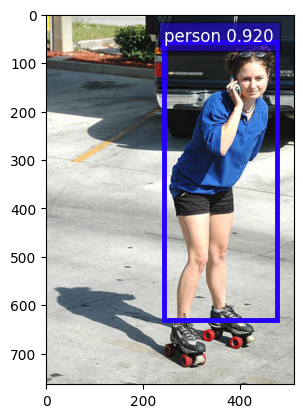

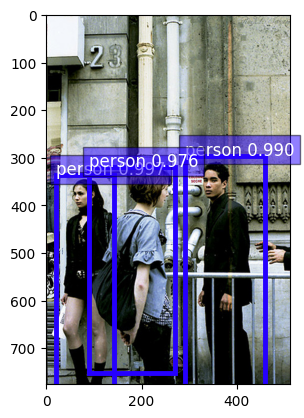

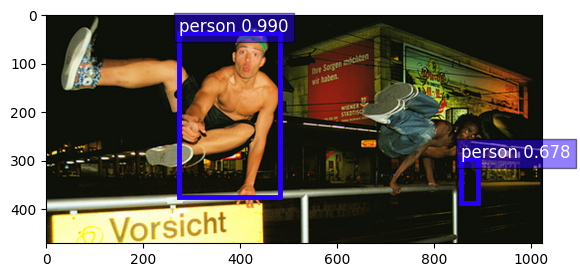

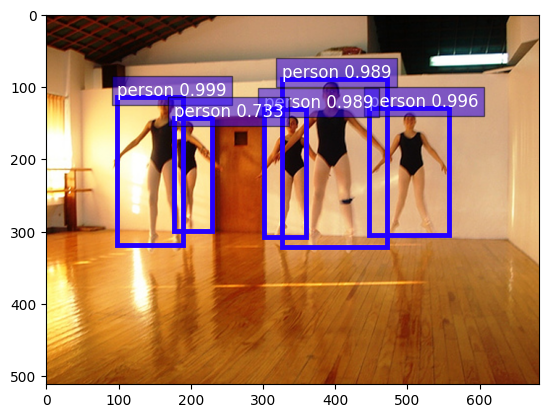

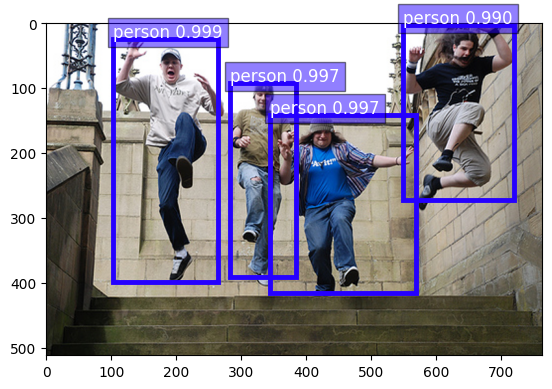

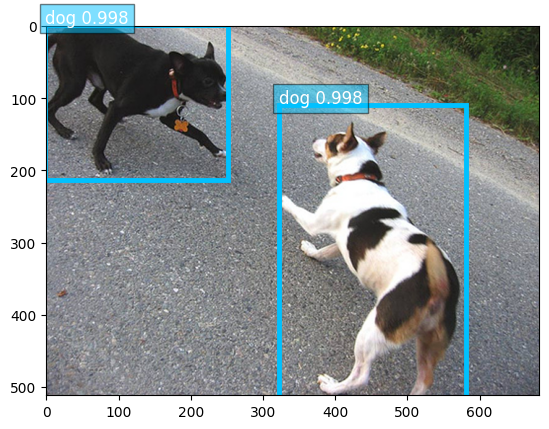

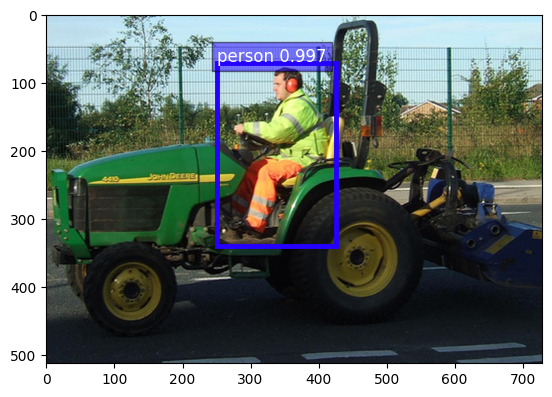

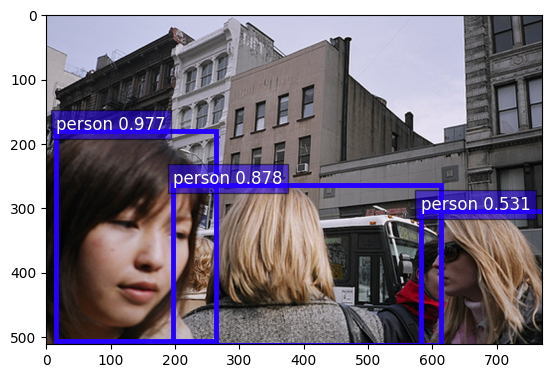

In [12]:
for pair in sampleKw[0:15]:
    fname, caps = pair
    testfname = f"/kaggle/input/flickr-image-dataset/flickr30k_images/flickr30k_images/{fname}"
    x, img = data.transforms.presets.yolo.load_test(testfname, short=512)
    print(f"preprocessed shape {x.shape}")
    ids, scores, boxes = net(x)
    print("yolo completed")
    ax = utils.viz.plot_bbox(img, boxes[0], scores[0], ids[0], class_names=net.classes)
    print(f"expected captions {caps}")
    print("plotted")